In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/amiratag/DataShapley.git

Cloning into 'DataShapley'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 79 (delta 0), reused 2 (delta 0), pack-reused 76
Unpacking objects: 100% (79/79), done.


In [3]:
import os
os.chdir("DataShapley")

In [171]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from Shapley import ShapNN
from DShap import DShap
from shap_utils import *
%matplotlib inline
import sys
import time
import numpy as np
from Shapley import ShapNN
from DShap import DShap
import matplotlib.pyplot as plt
import sklearn
from shap_utils import *
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/gdrive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [346]:
df = pd.read_csv('/gdrive/My Drive/CICIDS2017/dataset/cicids2017_merge.csv')

In [347]:
df.columns.values

array(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [348]:
df.columns[~(df != 0).any(axis=0)]
df = df.loc[:, (df != 0).any(axis=0)]
df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

parameters

In [349]:
trainsize = 6000
num_group = 60
num_test = 200
num_iteration = int(trainsize/num_group)*3

In [350]:
# df = df[['Bwd Packet Length Min', 'Subflow Fwd Bytes', 'Total Length of Fwd Packets','Fwd Packet Length Mean',
#          'Bwd Packet Length Std', 'Flow IAT Mean', 'Fwd IAT Min', 'Fwd IAT Mean',
#          'Flow Duration', 'Flow IAT Std', 'Active Min', 'Active Mean',
#          'Bwd IAT Min', 'Init_Win_bytes_forward', 
#          'ACK Flag Count', 'SYN Flag Count', 'Init_Win_bytes_backward',
#          'PSH Flag Count', 'Average Packet Size',
#     'Label']]
df = df[0:100000]
# df = df [['Subflow Fwd Bytes', 
#          'Bwd Packet Length Std',
#          'Flow Duration', 'Fwd IAT Mean','Init_Win_bytes_forward',
          
#     'Label']]
# df = df [['Subflow Fwd Bytes', 
#          'Bwd Packet Length Std',
#     'Label']]

In [351]:
dfb = df[df['Label'] == 'BENIGN']
dfd = df[df['Label'] == 'DDoS']

In [352]:
trainsize/0.4/2

7500.0

In [353]:
df = dfb[:int(trainsize/(1-0.4)/2)].append(dfd[:int(trainsize/(1-0.4)/2)])

In [354]:
df.shape

(10000, 71)

In [355]:
from sklearn.model_selection import train_test_split

In [356]:
seed = 1
train_set, test_set = train_test_split(df, test_size=0.4, random_state=seed)
train_X = train_set.drop('Label', axis=1)
train_y = train_set[['Label']]
test_X = test_set.drop('Label', axis=1)
test_y = test_set[['Label']]

In [357]:
from sklearn.preprocessing import StandardScaler

In [358]:
Scaler = StandardScaler()
train_X = Scaler.fit_transform(train_X)
test_X = Scaler.transform(test_X)

In [359]:
from sklearn.preprocessing import LabelEncoder

In [360]:
encode = LabelEncoder()

In [361]:
test_y = encode.fit_transform(test_y)
train_y = encode.fit_transform(train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [362]:
import sklearn.ensemble
import random

In [363]:
wrate = 0.4

In [364]:
train_y

array([1, 0, 0, ..., 0, 1, 0])

In [365]:
random.seed(seed)
for i in random.sample(list(np.arange(0,len(train_y))), int(len(train_y) * wrate)):
  train_y[i] = abs(train_y[i] - 1)

In [366]:
import math

In [367]:
sources = {}

In [368]:
for i in range(0, len(train_X), num_group):
    sources[int(i/num_group)] = np.array(list(range(i,i+num_group,1)))

In [369]:
len(train_X)

6000

In [370]:
sources

{0: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 1: array([ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
         86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119]),
 2: array([120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
        146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158,
        159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171,
        172, 173, 174, 175, 176, 177, 178, 179]),
 3: array([180, 181, 182, 183, 18

In [371]:
X, y = train_X, train_y
X_test, y_test = test_X, test_y
model = 'RandomForest'
problem = 'classification'

directory = './temp'
dshap = DShap(X, y, X_test, y_test, num_test, 
              sources=sources, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
dshap.run(num_iteration, err=0.1, loo_run=True, g_run=True)

Starting LOO score calculations!
LOO values calculated!
30 out of 300 TMC_Shapley iterations.
60 out of 300 TMC_Shapley iterations.
90 out of 300 TMC_Shapley iterations.
120 out of 300 TMC_Shapley iterations.
150 out of 300 TMC_Shapley iterations.
180 out of 300 TMC_Shapley iterations.
210 out of 300 TMC_Shapley iterations.
240 out of 300 TMC_Shapley iterations.
270 out of 300 TMC_Shapley iterations.
300 out of 300 TMC_Shapley iterations.
30 out of 300 TMC_Shapley iterations.
60 out of 300 TMC_Shapley iterations.
90 out of 300 TMC_Shapley iterations.
120 out of 300 TMC_Shapley iterations.
150 out of 300 TMC_Shapley iterations.
180 out of 300 TMC_Shapley iterations.
210 out of 300 TMC_Shapley iterations.
240 out of 300 TMC_Shapley iterations.
270 out of 300 TMC_Shapley iterations.
300 out of 300 TMC_Shapley iterations.
30 out of 300 TMC_Shapley iterations.
60 out of 300 TMC_Shapley iterations.
90 out of 300 TMC_Shapley iterations.
120 out of 300 TMC_Shapley iterations.
150 out of 300 TM

In [372]:
dshap.time1

[14178.834818840027, 13538.910681009293, 14270.23510336876, 14830.475842475891]

In [373]:
sum(dshap.time2)

56808.18488383293

In [374]:
dshap.time2

[47.35906744003296,
 46.901909828186035,
 45.795958280563354,
 46.745049476623535,
 46.78771448135376,
 46.37682914733887,
 47.837992668151855,
 47.52512264251709,
 47.16956806182861,
 46.501604318618774,
 47.71265649795532,
 46.44377565383911,
 46.44002318382263,
 47.08903360366821,
 46.82171702384949,
 46.8081111907959,
 46.90047073364258,
 47.31528854370117,
 47.486316204071045,
 47.01874256134033,
 46.814793825149536,
 45.64399862289429,
 46.24365210533142,
 46.562172651290894,
 46.66683292388916,
 45.9564471244812,
 46.62705039978027,
 46.80968356132507,
 46.357452154159546,
 46.797175884246826,
 46.92985963821411,
 46.15527033805847,
 47.06986331939697,
 46.642515420913696,
 46.53053641319275,
 46.19474673271179,
 47.22001647949219,
 47.334927558898926,
 46.918678760528564,
 47.07811236381531,
 46.6616575717926,
 46.89877939224243,
 46.861100912094116,
 46.738341093063354,
 47.543604373931885,
 46.83731722831726,
 47.48625588417053,
 47.54266571998596,
 47.65029740333557,
 46.360

In [375]:
dshap.time3

[(60, 0.07023143768310547),
 (120, 0.07592320442199707),
 (180, 0.07826948165893555),
 (240, 0.08564901351928711),
 (300, 0.0908970832824707),
 (360, 0.0994560718536377),
 (420, 0.10134220123291016),
 (480, 0.10360193252563477),
 (540, 0.11140131950378418),
 (600, 0.12801122665405273),
 (660, 0.13558316230773926),
 (720, 0.13351035118103027),
 (780, 0.13567042350769043),
 (840, 0.1453404426574707),
 (900, 0.14910888671875),
 (960, 0.16200733184814453),
 (1020, 0.1704409122467041),
 (1080, 0.17432260513305664),
 (1140, 0.17409062385559082),
 (1200, 0.17563390731811523),
 (1260, 0.18298029899597168),
 (1320, 0.21657347679138184),
 (1380, 0.20685386657714844),
 (1440, 0.213820219039917),
 (1500, 0.21453571319580078),
 (1560, 0.2286820411682129),
 (1620, 0.25769996643066406),
 (1680, 0.24477624893188477),
 (1740, 0.2448127269744873),
 (1800, 0.27166152000427246),
 (1860, 0.2688465118408203),
 (1920, 0.2793858051300049),
 (1980, 0.2598137855529785),
 (2040, 0.2940025329589844),
 (2100, 0.29

In [376]:
dshap.merge_results()

./temp/mem_tmc_0000.pkl


In [377]:
dshap.vals_tmc

array([1.17569444e-04, 1.17569444e-04, 1.17569444e-04, ...,
       6.34722222e-05, 6.34722222e-05, 6.34722222e-05])

In [378]:
len(dshap.vals_tmc)

6000

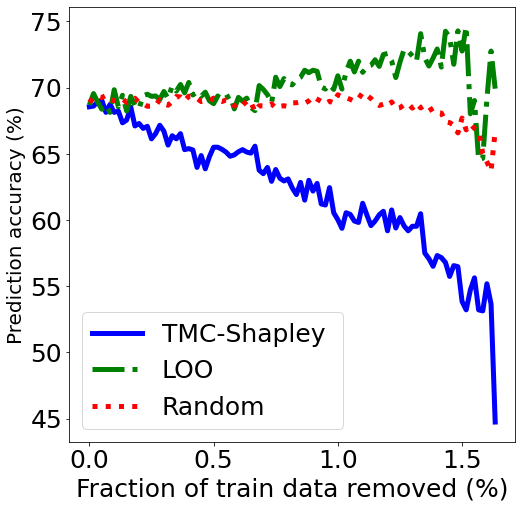

In [379]:
dshap.performance_plots([dshap.vals_tmc, dshap.vals_loo], num_plot_markers=200,sources=dshap.sources)

In [ ]:
dshap.performance_plots([dshap.vals_tmc, dshap.vals_loo], num_plot_markers=200,sources=None)

In [ ]:
convergence_plots(dshap.marginals_tmc)

In [ ]:
len(dshap.marginals_tmc)

In [2]:
sum([56808/1200])

47.34

In [3]:
result3 = [(60, 0.07023143768310547),
 (120, 0.07592320442199707),
 (180, 0.07826948165893555),
 (240, 0.08564901351928711),
 (300, 0.0908970832824707),
 (360, 0.0994560718536377),
 (420, 0.10134220123291016),
 (480, 0.10360193252563477),
 (540, 0.11140131950378418),
 (600, 0.12801122665405273),
 (660, 0.13558316230773926),
 (720, 0.13351035118103027),
 (780, 0.13567042350769043),
 (840, 0.1453404426574707),
 (900, 0.14910888671875),
 (960, 0.16200733184814453),
 (1020, 0.1704409122467041),
 (1080, 0.17432260513305664),
 (1140, 0.17409062385559082),
 (1200, 0.17563390731811523),
 (1260, 0.18298029899597168),
 (1320, 0.21657347679138184),
 (1380, 0.20685386657714844),
 (1440, 0.213820219039917),
 (1500, 0.21453571319580078),
 (1560, 0.2286820411682129),
 (1620, 0.25769996643066406),
 (1680, 0.24477624893188477),
 (1740, 0.2448127269744873),
 (1800, 0.27166152000427246),
 (1860, 0.2688465118408203),
 (1920, 0.2793858051300049),
 (1980, 0.2598137855529785),
 (2040, 0.2940025329589844),
 (2100, 0.2985107898712158),
 (2160, 0.31669187545776367),
 (2220, 0.3395357131958008),
 (2280, 0.34015846252441406),
 (2340, 0.34246397018432617),
 (2400, 0.34774351119995117),
 (2460, 0.3573932647705078),
 (2520, 0.3844447135925293),
 (2580, 0.3719022274017334),
 (2640, 0.38608741760253906),
 (2700, 0.3936939239501953),
 (2760, 0.4019804000854492),
 (2820, 0.4008333683013916),
 (2880, 0.41074562072753906),
 (2940, 0.43801331520080566),
 (3000, 0.4438498020172119),
 (3060, 0.4706449508666992),
 (3120, 0.48488521575927734),
 (3180, 0.45960259437561035),
 (3240, 0.4712975025177002),
 (3300, 0.4994826316833496),
 (3360, 0.49323320388793945),
 (3420, 0.49358153343200684),
 (3480, 0.5089471340179443),
 (3540, 0.5137333869934082),
 (3600, 0.5126581192016602),
 (3660, 0.5403091907501221),
 (3720, 0.5441687107086182),
 (3780, 0.5887506008148193),
 (3840, 0.560746431350708),
 (3900, 0.5669894218444824),
 (3960, 0.574110746383667),
 (4020, 0.6190378665924072),
 (4080, 0.6139020919799805),
 (4140, 0.5958683490753174),
 (4200, 0.6572487354278564),
 (4260, 0.6507079601287842),
 (4320, 0.6576640605926514),
 (4380, 0.6741898059844971),
 (4440, 0.6776654720306396),
 (4500, 0.7147097587585449),
 (4560, 0.6606786251068115),
 (4620, 0.6842169761657715),
 (4680, 0.6998476982116699),
 (4740, 0.7251608371734619),
 (4800, 0.7473199367523193),
 (4860, 0.7836511135101318),
 (4920, 0.8165738582611084),
 (4980, 0.7846882343292236),
 (5040, 0.772085428237915),
 (5100, 0.7650034427642822),
 (5160, 0.8222489356994629),
 (5220, 0.7711503505706787),
 (5280, 0.801194429397583),
 (5340, 0.7919011116027832),
 (5400, 0.8257913589477539),
 (5460, 0.8151283264160156),
 (5520, 0.8775022029876709),
 (5580, 0.8453178405761719),
 (5640, 0.8613665103912354),
 (5700, 0.8975489139556885),
 (5760, 0.9028801918029785),
 (5820, 0.8959474563598633),
 (5880, 0.9186909198760986),
 (5940, 0.9151806831359863),
 (6000, 0.9507689476013184)]

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
num_i = []
t = []
for i in result3:
  num_i.append(i[0])
  t.append(i[1])

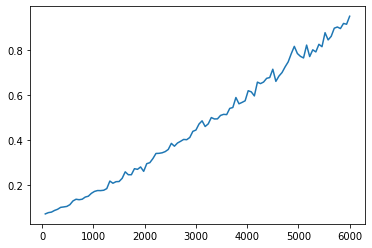

In [8]:
plt.plot(num_i, t)